In [132]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import seaborn
import cv2

from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment

In [2]:
from models_zoo.unet import UNet
from data.data import create_dataloader
from utils import load_model

In [6]:
%matplotlib inline

# Model

In [3]:
model = UNet()
model = load_model(model, "./weights/08-09-07-16.pth")
test_dataloader = create_dataloader(mode="test", num_samples=128, batch_size=32, shuffle=False, img_size=128)
img, mask = next(iter(test_dataloader))

Models is loaded from:  ./weights/08-09-07-16.pth
128


In [4]:
pred = model(img).detach().numpy()
print(pred.shape)

(32, 2, 128, 128)


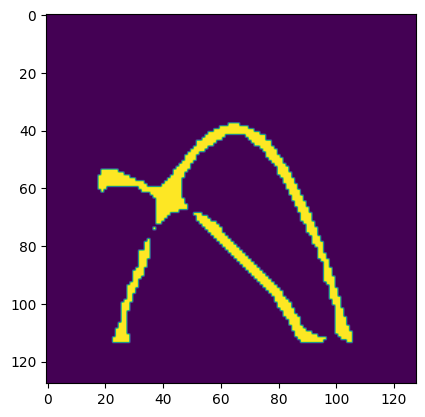

In [7]:
n = 12  # 14
origin = img[n]
my_img = pred[n][1]
my_img[my_img < 0.8] = 0
my_img[my_img > 0.5] = 1
my_img = np.roll(my_img, 0, axis=1)
plt.imshow(my_img)
plt.show()

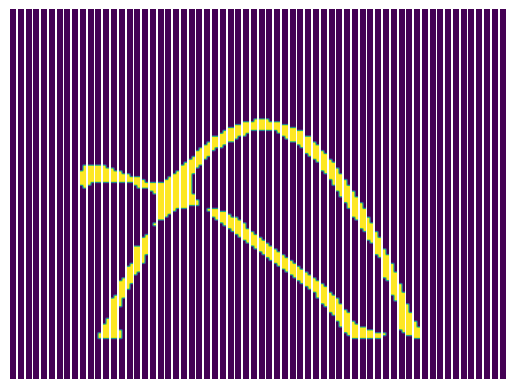

In [9]:
p_size = 2
n_piece = int(128 / p_size)

_, ax = plt.subplots(1, n_piece)
for i in range(n_piece):
    piece = my_img[:, i*p_size:(i+1)*p_size]
    ax[i].imshow(piece)
    ax[i].axis("off")

# Clustering

In [11]:
def get_cetners(img, n_of_cluster):
    y, x = np.where(img)
    kmeans = KMeans(n_clusters=n_of_cluster)
    kmeans.fit(np.column_stack((x, y)))
    return kmeans.cluster_centers_

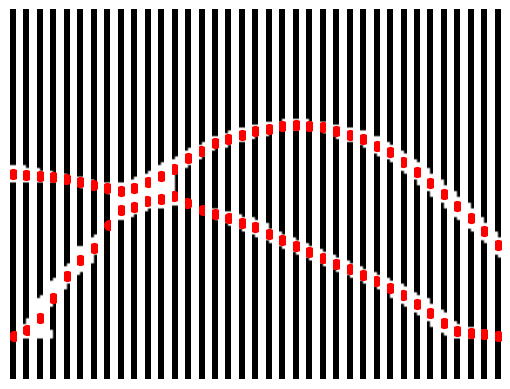

In [12]:
pice_n = 11

_, ax = plt.subplots(1, 48-pice_n)
for i in range(pice_n, 48): 
    piece = my_img[:, i*p_size:(i+1)*p_size]
    centers = get_cetners(piece, 2)
    ax[i-pice_n].imshow(piece, cmap='gray')
    ax[i-pice_n].scatter(centers[:, 0], centers[:, 1], c='red', s=50)
    ax[i-pice_n].axis("off")
plt.show()

# Utils

In [14]:
def relate_positions(positions, detections):
    object_positions = np.array(list(positions.values()))
    detection_positions = np.array(detections)
    cost_matrix = np.zeros((len(object_positions),
                            len(detection_positions)))
    for i, obj_pos in enumerate(object_positions):
        for j, det_pos in enumerate(detection_positions):
            cost_matrix[i, j] = np.linalg.norm(
                np.array(obj_pos) - np.array(det_pos))
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    assignment = {
        list(positions.keys())[i]: detections[j] for i, j in zip(
            row_ind, col_ind)}
    return assignment

positions = {0: [22, 100], 1: [22, 18]}
detections = np.array([[22, 22], [22, 35], [24, 105]])

assignment = relate_positions(positions, detections)
assignment

{0: array([ 24, 105]), 1: array([22, 22])}

In [15]:
def diff(v1, v2):
    return np.array([v2[0] - v1[0],
                     v2[1] - v1[1]])

# VectorSlope

In [17]:
n_plots = 2

plots = {0: [(None, None), (None, None), (None, None)],
         1: [(None, None), (None, None), (None, None)]}

predictions = {0:[], 1:[]}
expectations = {0:[], 1:[]}

inertia = 0.8

for e, step in enumerate(range(11, 48)):
    piece = my_img[:, step*p_size:(step+1)*p_size]
    # get new centers
    detection = get_cetners(piece, n_of_cluster=n_plots)
    detection += np.array([step*p_size, 0])
    # fill x0
    if e == 0:
        for key in plots.keys():
            plots[key][0] = detection[key]
    # update x0, fill dx
    if e == 1:
        for key in plots.keys():
            expectations[key] = plots[key][0]
        new_x = relate_positions(expectations, detection)
        for key in plots.keys():
            new_dx = diff(new_x[key], plots[key][0])
            plots[key][1] = new_dx
            plots[key][0] = new_x[key]
    # update x0 and dx, fill dx2
    if e == 2:
        for key in plots.keys():
            expectations[key] = plots[key][0]
        new_x = relate_positions(expectations, detection)
        for key in plots.keys():
            new_dx = diff(plots[key][0], new_x[key])
            new_dx2 = diff(plots[key][1], new_dx)
            plots[key][2] = new_dx2
            plots[key][1] = new_dx
            plots[key][0] = new_x[key]
    if e > 2:
        for key in plots.keys():
            expectations[key] = plots[key][0] + 10 * plots[key][1] + 5 * plots[key][2]
        new_x = relate_positions(expectations, detection)
        for key in plots.keys():
            new_dx = inertia*new_dx + (1 - inertia)*diff(plots[key][0], new_x[key])
            new_dx2 = inertia*new_dx2 + (1 - inertia)*diff(plots[key][1], new_dx)
            plots[key][2] = new_dx2
            plots[key][1] = new_dx
            plots[key][0] = new_x[key]
            predictions[key].append(plots[key][0])

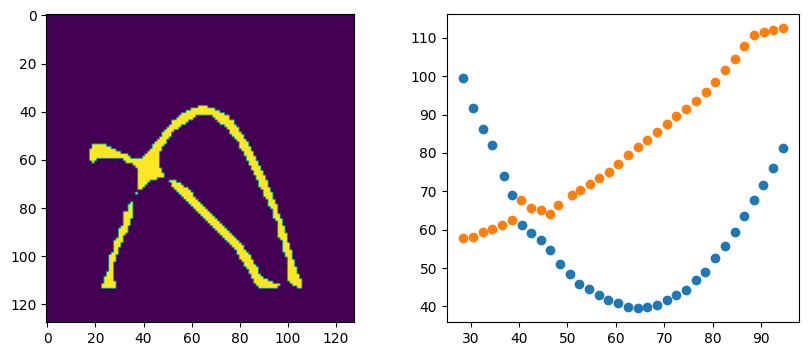

In [18]:
p0 = np.array(predictions[0])
p1 = np.array(predictions[1])

_, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].imshow(my_img)
ax[1].scatter(p0[:,0], p0[:,1])
ax[1].scatter(p1[:,0], p1[:,1])

Text(0.5, 1.0, 'Clustered')

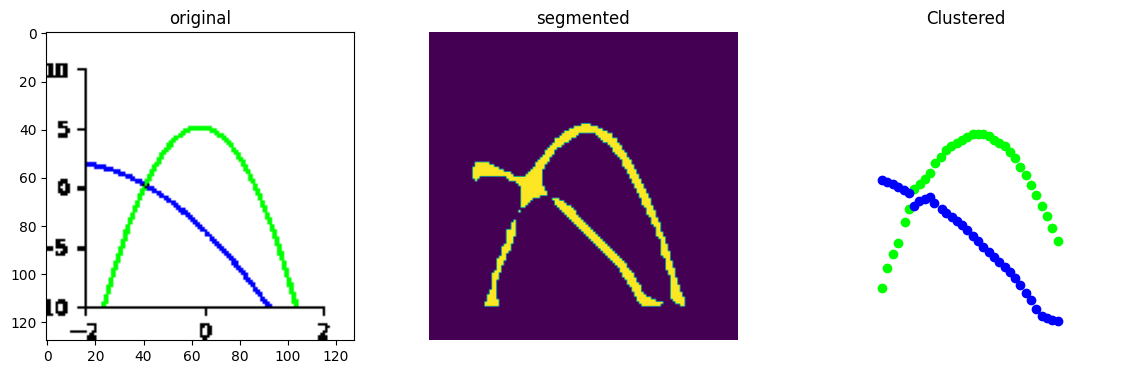

In [19]:
p0 = np.array(predictions[0])
p1 = np.array(predictions[1])

_, ax = plt.subplots(1, 3, figsize = (14, 4))
ax[0].imshow(np.transpose(origin, (1,2,0)))
ax[0].set_title("original")

ax[1].imshow(my_img)
ax[1].axis("off")
ax[1].set_title("segmented")

ax[2].scatter(p0[:,0], -p0[:,1], c = "lime")
ax[2].scatter(p1[:,0], -p1[:,1], c = "blue")
ax[2].set_ylim(-120, 0)
ax[2].set_xlim(0, 120)
ax[2].axis("off")
ax[2].set_title("Clustered")

# NumOfClusters

Cluster Centers:
 [[1.71428571 0.85714286]
 [5.28571429 3.71428571]]
2


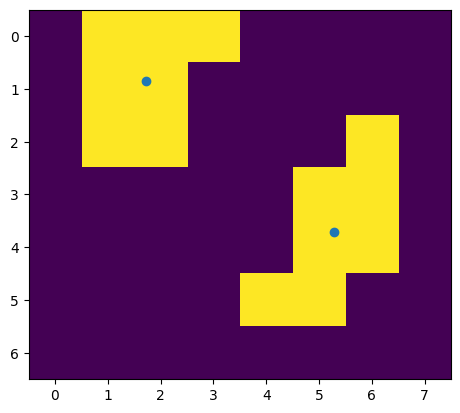

In [188]:
import numpy as np
from sklearn.cluster import DBSCAN

def find_cluster_centers(binary_mask, eps=2, min_samples=1):
    y, x = np.where(binary_mask)
    coordinates = np.column_stack((x, y))
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coordinates)
    labels = db.labels_
    unique_labels = set(labels)
    unique_labels.discard(-1)
    cluster_centers = []
    for label in unique_labels:
        cluster_points = coordinates[labels == label]
        cluster_center = cluster_points.mean(axis=0)
        cluster_centers.append(cluster_center)
    return np.array(cluster_centers)

def estimate_cluster_num(binary_mask, eps=2, min_samples=1):
    y, x = np.where(binary_mask)
    coordinates = np.column_stack((x, y))
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coordinates)
    labels = db.labels_
    unique_labels = set(labels)
    unique_labels.discard(-1)
    return len(unique_labels)

binary_mask = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
])

centers = find_cluster_centers(binary_mask)
print("Cluster Centers:\n", centers)

plt.imshow(binary_mask)
plt.scatter(centers[:, 0], centers[:, 1])

print(estimate_cluster_num(binary_mask))

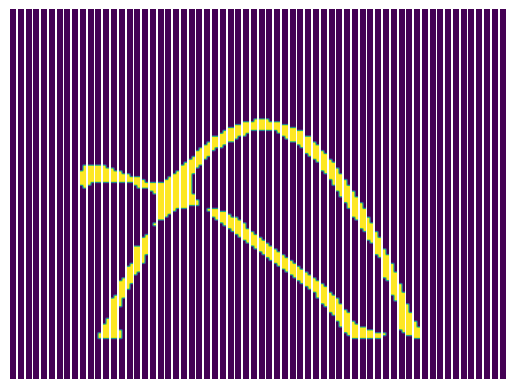

In [22]:
p_size = 2
n_piece = int(128 / p_size)

_, ax = plt.subplots(1, n_piece)
for i in range(n_piece):
    piece = my_img[:, i*p_size:(i+1)*p_size]
    ax[i].imshow(piece)
    ax[i].axis("off")

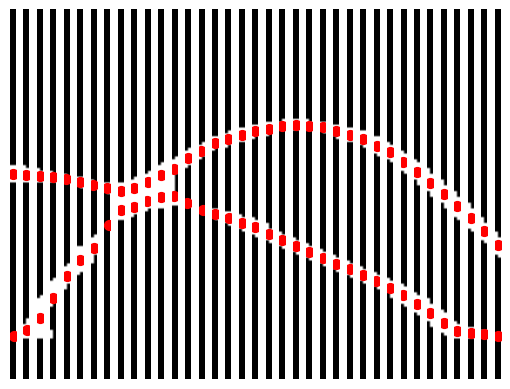

In [23]:
pice_n = 11

_, ax = plt.subplots(1, 48-pice_n)
for i in range(pice_n, 48): 
    piece = my_img[:, i*p_size:(i+1)*p_size]
    centers = get_cetners(piece, 2)
    ax[i-pice_n].imshow(piece, cmap='gray')
    ax[i-pice_n].scatter(centers[:, 0], centers[:, 1], c='red', s=50)
    ax[i-pice_n].axis("off")
plt.show()

we then need tree detections per each plot to set tree following parameters per plot: position (X), change of position (dX) and change of change of posiiton (dX2).
Based on these parameters we can estimate expected position on the coming plot as x + dx + dx2. Then new detections will be compared to the expected position and the nerest point to an expected posiotion will be asigned to a plot.

In [25]:
step_0 = 11
piece = my_img[:, i*p_size:(i+1)*p_size]
centers = get_cetners(piece, n_of_cluster=n_plots)
centers += np.array([i*p_size, 0])

In [ ]:
def get_centers(img, n_of_cluster):
    y, x = np.where(img)
    kmeans = KMeans(n_clusters=n_of_cluster)
    kmeans.fit(np.column_stack((x, y)))
    return kmeans.cluster_centers_

In [ ]:
# modal class
# dependancy injection 

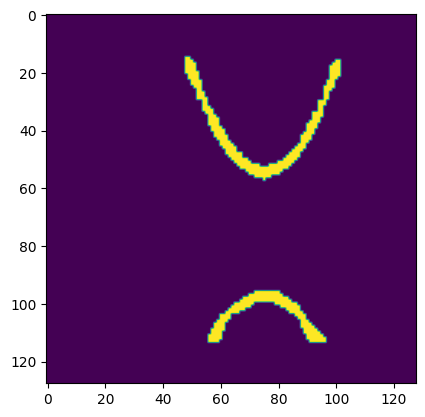

In [38]:
n = 11
origin = img[n]
my_img = pred[n][1]
my_img[my_img < 0.8] = 0
my_img[my_img > 0.5] = 1
plt.imshow(my_img)
plt.show()

In [434]:
class Tracker:

    """
    kinetics: i:[(None, None), (None, None), (None, None)], ...
    trace: i:[(None, None), ...], ...
    expectations: i:(None, None), ...
    """
    def __init__(self):
        self.num_of_plots = 0
        self.kinetics = {}
        self.trace = {}
        self.expectations = {}

class CCD:

    def __init__(self, tracker_dict, iniertia: float = 0.8, velocity: float = 10, accelaration: float = 5):

        self.plots = tracker_dict
        self.inertia = iniertia
        self.n_missdetections = 0
        self.v = velocity
        self.a = accelaration
        self.cluster_counter = 0

    def get_cetners(self, img, n_of_cluster):
        """
        use KMean to find clusters centers
        """
        y, x = np.where(img)
        kmeans = KMeans(n_clusters=n_of_cluster)
        kmeans.fit(np.column_stack((x, y)))
        return kmeans.cluster_centers_

    def estimate_cluster_num(self, img, eps=2, min_samples=4):
        """
        use DBSCAN to estimate number of clsuters on an image
        """
        y, x = np.where(img)
        coordinates = np.column_stack((x, y))
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(coordinates)
        labels = db.labels_
        unique_labels = set(labels)
        unique_labels.discard(-1)
        return len(unique_labels)

    def show_pice(self, img, n_clusters):
        """
        shows a given img (piece of img)
        indicated number of detected cluster
        """
        plt.imshow(img)
        plt.title(n_clusters)
        plt.show()

    def n_clusters_controle(self, n_clusters):
        """
        controles number of cluster reduction
        to prevent missdetectins on intersections
        Less amount of clusters should be detected
            several times in a raw to be confirmed
        """
        if n_clusters < self.plots.num_of_plots:
            self.cluster_counter += 1
            if self.cluster_counter == 2:
                self.cluster_counter = 0
                self.plots.num_of_plots -= 1
                return n_clusters
            else:
                return self.plots.num_of_plots
        else:
            self.cluster_counter = 0
            return n_clusters

    def assign(self, detections):
        """
        updates tracking objects with new positions;
        i. assign detectins to existin plots
            the rest is return for new plots update_positions()
        ii. new detections are added as new plots add_new_plots()
        iii. if new_positions are found
            then plots kinetics is updated update_kinetics()
        iv. expectations are updated with update_expectations()
        v. after all new detectins are added to trace
        """
        expectations = self.plots.expectations
        new_positions, new_detections = self.update_positions(expectations, detections)
        # a. add new plots
        self.add_new_plots(new_detections)
        # b. update kinetics
        if new_positions:
            self.update_kinetics(new_positions)
        # c. update expectations
        self.update_expectations()
        # d. update trace dict
        self.update_trace()

    def add_new_plots(self, new_detections):
        """
        adds new plot for new detections
        """
        for detection in new_detections:
            self.plots.kinetics[self.plots.num_of_plots] = [detection, (0, 0), (0, 0)]
            self.plots.trace[self.plots.num_of_plots] = []
            self.plots.num_of_plots += 1

    def update_kinetics(self, new_positions):
        """
        updating kinetics based on new detections and previouse positions;
        accounts inertia
        """
        for key in new_positions.keys():
            # new velocity
            dx_new = new_positions[key] - self.plots.kinetics[key][0]
            dx_last = np.array(self.plots.kinetics[key][1])
            # new acceleration
            dx2_new = dx_new - dx_last
            dx2_last = np.array(self.plots.kinetics[key][2])
            # updated kinetics
            self.plots.kinetics[key][2] = self.inertia * dx2_last + (1 - self.inertia) * dx2_new
            self.plots.kinetics[key][1] = self.inertia * dx_last + (1 - self.inertia) * dx_new
            self.plots.kinetics[key][0] = new_positions[key]

    def update_expectations(self):
        """
        updates expectations based on kinetics
        accounting velocity and acceleration coefficients
        """
        for key in self.plots.kinetics:
            x = np.array(self.plots.kinetics[key][0])
            dx = np.array(self.plots.kinetics[key][1])
            dx2 = np.array(self.plots.kinetics[key][2])
            self.plots.expectations[key] = x + self.v * dx + self.a * dx2

    def update_trace(self):
        for key in self.plots.kinetics.keys():
            self.plots.trace[key].append(self.plots.kinetics[key][0])

    def update_positions(self, positions, detections, max_distance_threshold=None):
        """
        Related new detections to existing plots
        and returns remaining detectins to asign to new plots
        """
        object_positions = np.array(list(positions.values()))
        detection_positions = np.array(detections)
        num_objects = len(object_positions)
        num_detections = len(detection_positions)
        # Initialize and fill the cost matrix
        cost_matrix = np.zeros((num_objects, num_detections))
        for i, obj_pos in enumerate(object_positions):
            for j, det_pos in enumerate(detection_positions):
                cost_matrix[i, j] = np.linalg.norm(np.array(obj_pos) - np.array(det_pos))
        # Perform the assignment
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        assignment = {}
        assigned_detections = set()
        for i, j in zip(row_ind, col_ind):
            if max_distance_threshold is None or cost_matrix[i, j] <= max_distance_threshold:
                assignment[list(positions.keys())[i]] = detections[j]
                assigned_detections.add(j)
        # Determine remaining detections
        remaining_detections = [detections[j] for j in range(num_detections) if j not in assigned_detections]
        return assignment, remaining_detections

    def run(self, my_img, p_size: int = 1):
        """
        splits image into pieces and implements cluster tracking slice by slice"""
        n_steps = my_img.shape[-1] // p_size
        for e, step in enumerate(range(0, n_steps)):
            # get piece of img
            piece = my_img[:, step * p_size:(step + 1) * p_size]
            # n of cluster changed?
            if np.all(piece == 0):
                n_of_clusters = 0
            else:
                n_of_clusters = self.estimate_cluster_num(piece, eps=2, min_samples=1)
            # make detections
            if n_of_clusters > 0:
                n_of_clusters = self.n_clusters_controle(n_clusters=n_of_clusters)
                detections = self.get_cetners(piece, n_of_cluster=n_of_clusters)
                detections += np.array([step * p_size, 0])
                # now solving an asignment problem
                self.assign(detections)

Text(0.5, 1.0, 'Clustered')

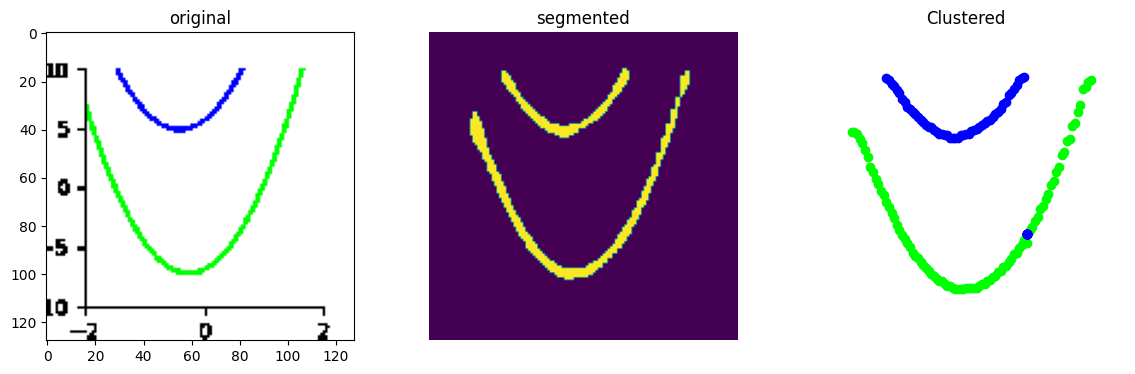

In [493]:
n = 7
origin = img[n]
my_img = pred[n][1]
my_img[my_img < 0.8] = 0
my_img[my_img > 0.8] = 1

tracker = Tracker()
obj = CCD(tracker, iniertia=0.7, velocity=1, accelaration=3)
obj.run(my_img, p_size=1)

trace = tracker.trace
plot = {}
for key in trace.keys():
    plot[key] = np.array(trace[key])

LIST_OF_COLOURS = {0: "lime", 1: "blue", 2: "red", 3: "magenta"}

_, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].imshow(np.transpose(origin, (1, 2, 0)))
ax[0].set_title("original")

ax[1].imshow(my_img)
ax[1].axis("off")
ax[1].set_title("segmented")

for key in trace.keys():
    ax[2].scatter(plot[key][:, 0], -plot[key][:, 1], c=LIST_OF_COLOURS[key])
ax[2].set_ylim(-120, 0)
ax[2].set_xlim(0, 120)
ax[2].axis("off")
ax[2].set_title("Clustered")

# Fit

In [464]:
from scipy.optimize import curve_fit

class FitExtract():

    def __init__(self) -> None:
        pass

    def rescale(self, dictx):
        rescaled = {}
        for key in dictx:
            new_key = (key - 66) / 24
            rescaled[new_key] = ((-1) * dictx[key] + 61) / 4
        return rescaled

    def my_func(self, x, a11, a12, a13):
        y1 = np.poly1d([a11, a12, a13])
        return y1(x)

    def fit(self, t_rescaled):
        x_values = np.array(list(t_rescaled.keys()))
        y_values = np.array(list(t_rescaled.values()))
        bnds = [(-8, -8, -8), (8, 8, 8)]
        coefficients, _ = curve_fit(self.my_func, x_values, y_values, bounds=bnds)
        return coefficients

    def fit_on(self, plot):
        t_rescaled = self.rescale(plot)
        coefs = self.fit(t_rescaled)
        return coefs

fit_machine = FitExtract()

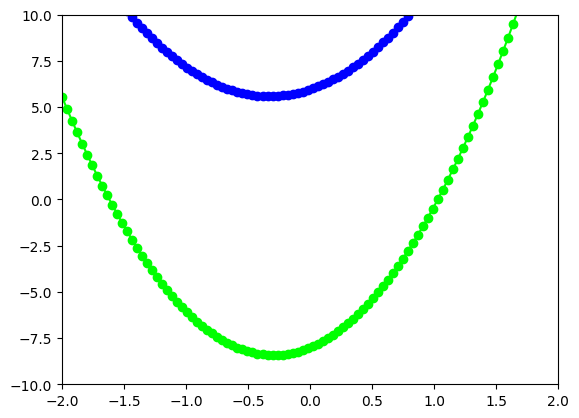

In [505]:
for key in trace.keys():
    t_dict = {p[0]:p[1] for p in plot[key]}
    coefs = fit_machine.fit_on(t_dict)
    my_f = np.poly1d(coefs)
    y = [my_f(x) for x in np.linspace(-2, 2, 100)]
    plt.plot(np.linspace(-2, 2, 100), y, c = LIST_OF_COLOURS[key], marker = "o")

plt.ylim(-10, 10)
plt.xlim(-2, 2)
plt.show()

# TextExtraction

In [123]:
# Test of LSTM

# Create an LSTM layer
# input_size: Number of expected features in the input (e.g., embedding size or features per time step)
# hidden_size: Number of features in the hidden state
# num_layers: Number of recurrent layers (stacked LSTMs)
# batch_first: If True, the input and output tensors are expected to have shape (batch, seq, feature)
lstm = nn.LSTM(input_size=10, hidden_size=20, num_layers=2, batch_first=True)

# Generate a random input tensor
# Shape: (batch_size, sequence_length, input_size)
input_tensor = torch.randn(3, 5, 10)  # Example with batch_size=3, sequence_length=5, input_size=10


In [130]:
# Simple CRNN

class CRNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CRNN, self).__init__()
        
        # Define the CNN part
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # output: (32, 10, 10)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: (32, 5, 5)
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # output: (64, 5, 5)
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # output: (64, 2, 2)
        )
        
        # Define the LSTM part
        self.rnn = nn.LSTM(input_size=64, hidden_size=128, num_layers=2, bidirectional=True, batch_first=True)
        
        # Fully connected layer for classification
        self.fc = nn.Linear(128 * 2, num_classes)  # num_classes = 10 for digits 0-9
        
    def forward(self, x):
        # Pass through CNN
        x = self.cnn(x)  # output: (batch_size, 64, 2, 2)
        
        # Reshape to (batch_size, sequence_length, features)
        x = x.view(x.size(0), 4, 64)  # output: (batch_size, 4, 64)
        
        # Pass through RNN
        x, _ = self.rnn(x)  # output: (batch_size, 4, 256)
        
        # Pass through fully connected layer (apply to each sequence element)
        x = self.fc(x)  # output: (batch_size, 4, num_classes)
        
        # Apply softmax to get probabilities
        x = F.log_softmax(x, dim=2)  # output: (batch_size, 4, num_classes)
        
        return x

# Example usage
model = CRNN(num_classes=10)
input_image = torch.rand(1, 1, 10, 10)  # Batch size of 1, 1 channel (grayscale), 10x10 image
output = model(input_image)

# The output will be a tensor of shape (batch_size, sequence_length, num_classes)
print(output.shape)


torch.Size([1, 4, 10])


In [131]:
# Final number extraction

# Simulated output tensor for a number "42"
# Shape: (batch_size, 4, 10), with batch_size = 1 for simplicity
output = torch.tensor([
    [
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],  # Low confidence for any digit
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],  # Low confidence for any digit
        [0.0, 0.1, 0.8, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # High confidence for digit 4
        [0.1, 0.0, 0.0, 0.0, 0.8, 0.1, 0.0, 0.0, 0.0, 0.0],  # High confidence for digit 2
    ]
])

# Extract predicted digits
predicted_digits = torch.argmax(output, dim=2)  # Shape: (batch_size, 4)
print("Predicted Digits:", predicted_digits)

# Convert to a number (assuming the output should be concatenated)
numbers = [int(''.join(map(str, digits.tolist()))) for digits in predicted_digits]
print("Interpreted Number:", numbers)


Predicted Digits: tensor([[0, 0, 2, 4]])
Interpreted Number: [24]
